##### Copyright 2020 The TensorFlow Hub Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 3.8 MB/s 
     |████████████████████████████████| 462 kB 55.5 MB/s 


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 33.9 MB/s 
     |████████████████████████████████| 1.2 MB 59.4 MB/s 
     |████████████████████████████████| 352 kB 55.5 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 237 kB 46.5 MB/s 


In [ ]:
!pip install translators

     |████████████████████████████████| 6.4 MB 8.1 MB/s 
     |████████████████████████████████| 63 kB 758 kB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 58 kB 4.7 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
  Created wheel for PyExecJS: filename=PyExecJS-1.5.1-py3-none-any.whl size=14598 sha256=8671fd735e6509dda27d040fbd084f36e73b77995422815d3362d022d766849f
  Stored in directory: /root/.cache/pip/wheels/9a/ee/03/da5c0b4a8c13362beeb844eb913bbe58a89bde1de2b9157007
Successfully built PyExecJS
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
import os
import shutil


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np

tf.get_logger().setLevel('ERROR')

# Load twitter datasets

In [ ]:
labels = ["NOT", "OFF"]
list_of_labels = []
data_set = []
longest_line = 0

with open("OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt", 'r', encoding = 'utf-8') as f:
  print(f.readline())
  for lines in f:
    line = f.readline().split(" ")
    line[0] = line[0].split("\t")[1]
    temp = line[-1].split("\t")
    temp[-1] = temp[-1].split("\n")[0]
    line[-1] = temp[0]
    # line = ' '.join(line)
    if len(line) > longest_line:
      longest_line = len(line)
    list_of_labels.append(temp[1:])
    data_set.append(line)
    # print(line, temp[1:])
print("longest line: ", longest_line)
for i in range(len(data_set)):
  while len(data_set[i]) < longest_line:
    data_set[i].append(" ")

data_set = tf.convert_to_tensor(data_set)
data_set = tf.data.Dataset.from_tensor_slices(data_set)


for i in range(len(list_of_labels)):
  if list_of_labels[i][0] == "NOT":
    list_of_labels[i] = 0
  else: 
    list_of_labels[i] = 1

list_of_labels = tf.convert_to_tensor(list_of_labels)
list_of_labels = tf.data.Dataset.from_tensor_slices(list_of_labels)

for data, label in zip(enumerate(data_set), enumerate(list_of_labels)):
  data = (data, label)
# for i, data in enumerate(data_set):
#   if list_of_labels[i][0] == "NOT":
#     data = (data, tf.convert_to_tensor([0]))
#   else:
#     data = (data, tf.convert_to_tensor([1]))
# labels = tf.convert_to_tensor(labels)
print(data_set)

FileNotFoundError: ignored

In [ ]:
labels_off = []
labels_not = []
data_set_off = []
data_set_not = []
longest_line = 0

with open("OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt", 'r', encoding = 'utf-8') as f:
  f.readline()
  for lines in f:
    line = f.readline().split("\t", 1)
    textAndLabels = line[1].split("\t", 1)
    label = textAndLabels[1].split("\t")[0]
    if label == "OFF":
          labels_off.append(line[0])
          data_set_off.append(textAndLabels[0])
    elif label == "NOT":
          labels_not.append(line[0])
          data_set_not.append(textAndLabels[0])
    else:
      print("Somethings wrong")
    #line = textAndLabels[0]
    #labels.append(label)
    # line = ' '.join(line)
    if len(textAndLabels[0]) > longest_line:
      longest_line = len(textAndLabels[0])
    #data_set.append(line)
    # print(line, temp[1:])
print("longest line: ", longest_line)
for i in range(len(data_set_off)):
  data_set_off[i].ljust(longest_line - len(data_set_off[i]))
for i in range(len(data_set_not)):
  data_set_not[i].ljust(longest_line - len(data_set_not[i]))

print(labels_off)

longest line:  329
['90194', '62688', '97670', '52415', '13384', '28195', '82904', '77665', '25440', '14726', '98992', '33853', '53264', '47153', '45068', '93119', '91001', '66349', '77294', '16940', '28841', '68629', '32897', '95444', '62481', '68840', '32916', '18547', '82339', '53501', '31853', '70838', '16885', '34317', '36289', '44015', '10133', '29497', '14808', '33322', '80497', '95200', '62107', '33096', '81470', '54559', '14285', '42133', '38043', '76709', '47009', '97936', '98382', '71577', '34443', '22185', '77089', '79972', '30085', '97580', '54991', '58548', '51592', '56068', '88585', '97329', '14118', '63792', '82293', '61533', '78473', '92935', '86626', '18702', '27045', '78567', '80107', '93419', '97831', '83457', '63762', '50390', '30426', '66497', '95987', '21223', '25469', '67895', '69106', '64626', '39729', '93056', '59690', '23311', '33600', '58576', '69004', '28518', '77529', '25305', '60071', '66631', '70446', '26783', '23818', '36639', '34178', '66373', '83576',

In [ ]:
import random
import numpy as np
random.shuffle(data_set_off)
random.shuffle(data_set_not)

offensive_test = []
not_test = []

print(len(data_set_off))
print(len(data_set_not))
split_dataset = np.split(data_set_off, [int(len(data_set_off)*0.7)])
split_dataset2 = np.split(data_set_not, [int(len(data_set_not)*0.7)])

print(len(split_dataset[0]))
print(len(split_dataset2[0]))
print("test sizes:")
print(len(split_dataset[1]))
print(len(split_dataset2[1]))

2209
4411
1546
3087
test sizes:
663
1324


In [ ]:
import translators as ts

index = 0
for tweet in split_dataset[0]:
  with open("twitterDataset/train/off/"+str(index)+".txt","w") as f:
    f.write(tweet)
  index+=1

  translated = ts.google(tweet, to_language='fr')
  augmented = ts.sogou(translated)
  with open("twitterDataset/train/off/"+str(index)+".txt","w") as f:
    f.write(augmented)
  index+=1

index = 0
for tweet in split_dataset2[0]:
  with open("twitterDataset/train/not/"+str(index)+".txt","w") as f:
    f.write(tweet)
  index+=1

  translated = ts.google(tweet, to_language='fr')
  augmented = ts.sogou(translated)
  with open("twitterDataset/train/not/"+str(index)+".txt","w") as f:
    f.write(augmented)
  index+=1

index = 0
for tweet in split_dataset[1]:
  with open("twitterDataset/test/off/"+str(index)+".txt","w") as f:
    f.write(tweet)
  index+=1

  translated = ts.google(tweet, to_language='fr')
  augmented = ts.sogou(translated)
  with open("twitterDataset/test/off/"+str(index)+".txt","w") as f:
    f.write(augmented)
  index+=1

index = 0
for tweet in split_dataset2[1]:
  with open("twitterDataset/test/not/"+str(index)+".txt","w") as f:
    f.write(tweet)
  index+=1

  translated = ts.google(tweet, to_language='fr')
  augmented = ts.sogou(translated)
  with open("twitterDataset/test/not/"+str(index)+".txt","w") as f:
    f.write(augmented)
  index+=1

In [ ]:
# Jupyter notebook adds extra folder which makes another class which fucks binaryloss
!rm -r twitterDataset/train/.ipynb_checkpoints
!rm -r twitterDataset/test/.ipynb_checkpoints

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'twitterDataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
print(class_names)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'twitterDataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'twitterDataset/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9266 files belonging to 2 classes.
Using 7413 files for training.
['not', 'off']
Found 9266 files belonging to 2 classes.
Using 1853 files for validation.
Found 3974 files belonging to 2 classes.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'electra_small'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = iter(data_set).next()
print(text_test)
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

NameError: ignored

As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire text.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the text.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

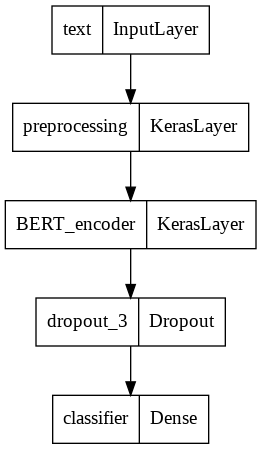

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), get_f1]

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = 0.1*int(num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,# data_set, y=list_of_labels,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/5
232/232 [==============================] - 2221s 10s/step - loss: 0.5906 - binary_accuracy: 0.6748 - get_f1: 0.2366 - val_loss: 0.4642 - val_binary_accuracy: 0.7733 - val_get_f1: 0.5352
Epoch 2/5
232/232 [==============================] - 2210s 10s/step - loss: 0.4571 - binary_accuracy: 0.7835 - get_f1: 0.5797 - val_loss: 0.4287 - val_binary_accuracy: 0.8095 - val_get_f1: 0.6501
Epoch 3/5
232/232 [==============================] - 2209s 10s/step - loss: 0.3860 - binary_accuracy: 0.8218 - get_f1: 0.6793 - val_loss: 0.4157 - val_binary_accuracy: 0.8241 - val_get_f1: 0.6836
Epoch 4/5
194/232 [========================>.....] - ETA: 5:39 - loss: 0.3327 - binary_accuracy: 0.8502 - get_f1: 0.7326

## Best training acc & f1 / val acc & f1 / test acc & f1
- small_bert/bert_en_uncased_L-4_H-512_A-8/1, lr= 3e-5: 0.7186 & 0.3602 / 0.7573 & 0.4957 / 0.7698
- electra_small, lr= 3e-5: 0.6792 & 0.1151 / 0.6950 & 0.1390 / 0.6860 & 0.1346 
- electra_small, lr= 3e-4: 0.8468 & 0.7301 / 0.7829 & 0.6366 / 0.7755 & 0.6627

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy, f1 = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'twitterHS'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
!zip -r twitterModel.zip twitterHS_bert

  adding: twitterHS_bert/ (stored 0%)
  adding: twitterHS_bert/variables/ (stored 0%)
  adding: twitterHS_bert/variables/variables.index (deflated 75%)
  adding: twitterHS_bert/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: twitterHS_bert/assets/ (stored 0%)
  adding: twitterHS_bert/assets/vocab.txt (deflated 53%)
  adding: twitterHS_bert/saved_model.pb (deflated 92%)
  adding: twitterHS_bert/keras_metadata.pb (deflated 85%)


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)